# Use keras-tuner to optimize model on TriFeature data for multiplicity determination

In [1]:
# For this network, GPU is slower than CPU -> Disable CUDA
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np
import pandas as pd
import sys

sys.path.append("..")
from helpers import filename_for

import tensorflow
from tensorflow import keras
import kerastuner

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)
print("keras-tuner", kerastuner.__version__)

Welcome to JupyROOT 6.16/00
tensorflow 2.1.0
keras 2.2.4-tf
keras-tuner 1.0.1


In [3]:
num_dp = 30
max_neutrons = 4
label = "nPH"

In [4]:
files = [
    filename_for(15, 30, 600, 500, n, "inclxx", s, "trifeature.pkl")
    for n in range(1, max_neutrons + 1)
    for s in range(20)
]
dfs = [pd.read_pickle(file) for file in files]
data = pd.concat(dfs, ignore_index=True).sample(frac=1)
print(data.shape)

(800000, 6)


In [5]:
msk = np.random.rand(len(data)) < 0.8
# Create one entry with zero everything to prevent NaN-PDF if no entry with LABEL=0 exists
msk[0] = True
data.loc[0] = [0, 0, 0, 0, 0, 0]
traindata = data[msk]
testdata = data[~msk]

print(traindata.shape)
print(testdata.shape)

x_train = traindata[["nHits", "nClus", "Edep"]].values
y_train = keras.utils.to_categorical(traindata[[label]].values.ravel())

x_val = testdata[["nHits", "nClus", "Edep"]].values
y_val = keras.utils.to_categorical(testdata[[label]].values.ravel());

(639606, 6)
(160394, 6)


In [6]:
def build_model(hp):
    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
            units=hp.Int("unitsl1", min_value=10, max_value=500, step=30),
            activation="relu",
            input_shape=(3,),
        )
    )
    model.add(
        keras.layers.Dense(
            units=hp.Int("unitsl2", min_value=5, max_value=50, step=5),
            activation="relu",
        )
    )
    model.add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

    optimizer = keras.optimizers.Adagrad(
        hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    )
    loss = keras.losses.categorical_crossentropy
    model.compile(loss=loss, optimizer=optimizer, metrics=["acc"])
    return model

In [7]:
tuner = kerastuner.tuners.RandomSearch(
    build_model,
    objective="val_acc",
    max_trials=5,
    executions_per_trial=3,
    directory="out",
    project_name="simple-tuner",
)
tuner.search_space_summary()

2020-05-14 22:00:19.028289: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/jmayer/Simulations/R3BRoot/build/lib:/data/jmayer/Simulations/2019-09-04/ucesb/hbook:/data/jmayer/Simulations/2019-09-04/FairRoot/lib:/data/jmayer/Simulations/2019-09-04/FairSoft/lib/root:/data/jmayer/Simulations/2019-09-04/FairSoft/lib
2020-05-14 22:00:19.028490: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: UNKNOWN ERROR (303)
2020-05-14 22:00:19.028567: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thanatos.ikp.uni-koeln.de): /proc/driver/nvidia/version does not exist
2020-05-14 22:00:19.028926: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020

In [8]:
tuner.search(
    x_train,
    y_train,
    epochs=20,
    batch_size=1000,
    validation_data=(x_val, y_val),
    verbose=2,
)

Train on 639606 samples, validate on 160394 samples
Epoch 1/20
639606/639606 - 21s - loss: 2.9064 - acc: 0.3145 - val_loss: 1.5743 - val_acc: 0.2725
Epoch 2/20
639606/639606 - 13s - loss: 1.2176 - acc: 0.4556 - val_loss: 1.0849 - val_acc: 0.4568
Epoch 3/20
639606/639606 - 12s - loss: 1.0308 - acc: 0.5643 - val_loss: 0.9759 - val_acc: 0.6436
Epoch 4/20
639606/639606 - 13s - loss: 0.9444 - acc: 0.6331 - val_loss: 0.9125 - val_acc: 0.7132
Epoch 5/20
639606/639606 - 12s - loss: 0.8972 - acc: 0.6528 - val_loss: 0.8593 - val_acc: 0.7210
Epoch 6/20
639606/639606 - 12s - loss: 0.8573 - acc: 0.6631 - val_loss: 0.8265 - val_acc: 0.6729
Epoch 7/20
639606/639606 - 11s - loss: 0.8231 - acc: 0.6700 - val_loss: 0.8065 - val_acc: 0.6216
Epoch 8/20
639606/639606 - 12s - loss: 0.7871 - acc: 0.6918 - val_loss: 0.7699 - val_acc: 0.6628
Epoch 9/20
639606/639606 - 11s - loss: 0.7543 - acc: 0.7122 - val_loss: 0.7527 - val_acc: 0.7004
Epoch 10/20
639606/639606 - 14s - loss: 0.7275 - acc: 0.7233 - val_loss: 0.

Train on 639606 samples, validate on 160394 samples
Epoch 1/20
639606/639606 - 16s - loss: 23.3826 - acc: 0.2634 - val_loss: 12.6080 - val_acc: 0.2625
Epoch 2/20
639606/639606 - 13s - loss: 7.1819 - acc: 0.2504 - val_loss: 4.8840 - val_acc: 0.2426
Epoch 3/20
639606/639606 - 14s - loss: 4.3675 - acc: 0.2481 - val_loss: 3.9036 - val_acc: 0.2493
Epoch 4/20
639606/639606 - 14s - loss: 3.4551 - acc: 0.2510 - val_loss: 3.0404 - val_acc: 0.2500
Epoch 5/20
639606/639606 - 12s - loss: 2.6409 - acc: 0.2507 - val_loss: 2.2680 - val_acc: 0.2491
Epoch 6/20
639606/639606 - 14s - loss: 1.9346 - acc: 0.2486 - val_loss: 1.6484 - val_acc: 0.2466
Epoch 7/20
639606/639606 - 11s - loss: 1.5029 - acc: 0.2430 - val_loss: 1.4273 - val_acc: 0.2494
Epoch 8/20
639606/639606 - 11s - loss: 1.4097 - acc: 0.2498 - val_loss: 1.4000 - val_acc: 0.2511
Epoch 9/20
639606/639606 - 14s - loss: 1.3950 - acc: 0.2520 - val_loss: 1.3915 - val_acc: 0.2525
Epoch 10/20
639606/639606 - 13s - loss: 1.3883 - acc: 0.2543 - val_loss: 

Train on 639606 samples, validate on 160394 samples
Epoch 1/20
639606/639606 - 21s - loss: 4.8567 - acc: 0.2736 - val_loss: 1.5059 - val_acc: 0.2842
Epoch 2/20
639606/639606 - 14s - loss: 1.4868 - acc: 0.2876 - val_loss: 1.4668 - val_acc: 0.2864
Epoch 3/20
639606/639606 - 14s - loss: 1.4566 - acc: 0.2887 - val_loss: 1.4448 - val_acc: 0.2881
Epoch 4/20
639606/639606 - 15s - loss: 1.4378 - acc: 0.2905 - val_loss: 1.4284 - val_acc: 0.2900
Epoch 5/20
639606/639606 - 17s - loss: 1.4230 - acc: 0.2923 - val_loss: 1.4148 - val_acc: 0.2917
Epoch 6/20
639606/639606 - 17s - loss: 1.4102 - acc: 0.2940 - val_loss: 1.4028 - val_acc: 0.2931
Epoch 7/20
639606/639606 - 14s - loss: 1.3987 - acc: 0.2952 - val_loss: 1.3919 - val_acc: 0.2946
Epoch 8/20
639606/639606 - 15s - loss: 1.3886 - acc: 0.2966 - val_loss: 1.3826 - val_acc: 0.2967
Epoch 9/20
639606/639606 - 16s - loss: 1.3797 - acc: 0.2981 - val_loss: 1.3742 - val_acc: 0.2975
Epoch 10/20
639606/639606 - 16s - loss: 1.3717 - acc: 0.2994 - val_loss: 1.

Train on 639606 samples, validate on 160394 samples
Epoch 1/20
639606/639606 - 2s - loss: 2.7306 - acc: 0.3235 - val_loss: 1.3701 - val_acc: 0.4106
Epoch 2/20
639606/639606 - 1s - loss: 1.3142 - acc: 0.4317 - val_loss: 1.2114 - val_acc: 0.5118
Epoch 3/20
639606/639606 - 1s - loss: 1.1343 - acc: 0.5031 - val_loss: 1.0700 - val_acc: 0.5404
Epoch 4/20
639606/639606 - 1s - loss: 1.0359 - acc: 0.5592 - val_loss: 0.9932 - val_acc: 0.5536
Epoch 5/20
639606/639606 - 1s - loss: 0.9767 - acc: 0.5958 - val_loss: 0.9424 - val_acc: 0.6327
Epoch 6/20
639606/639606 - 1s - loss: 0.9390 - acc: 0.6099 - val_loss: 0.9106 - val_acc: 0.6149
Epoch 7/20
639606/639606 - 1s - loss: 0.9064 - acc: 0.6246 - val_loss: 0.8871 - val_acc: 0.6181
Epoch 8/20
639606/639606 - 1s - loss: 0.8734 - acc: 0.6486 - val_loss: 0.8704 - val_acc: 0.6182
Epoch 9/20
639606/639606 - 1s - loss: 0.8499 - acc: 0.6571 - val_loss: 0.8513 - val_acc: 0.6117
Epoch 10/20
639606/639606 - 1s - loss: 0.8244 - acc: 0.6727 - val_loss: 0.8060 - val

Train on 639606 samples, validate on 160394 samples
Epoch 1/20
639606/639606 - 2s - loss: 1.6313 - acc: 0.2678 - val_loss: 1.4292 - val_acc: 0.2778
Epoch 2/20
639606/639606 - 2s - loss: 1.3164 - acc: 0.2908 - val_loss: 1.2855 - val_acc: 0.3004
Epoch 3/20
639606/639606 - 2s - loss: 1.2767 - acc: 0.3142 - val_loss: 1.2589 - val_acc: 0.3220
Epoch 4/20
639606/639606 - 2s - loss: 1.2490 - acc: 0.3412 - val_loss: 1.2438 - val_acc: 0.3448
Epoch 5/20
639606/639606 - 2s - loss: 1.2281 - acc: 0.3648 - val_loss: 1.2146 - val_acc: 0.3612
Epoch 6/20
639606/639606 - 2s - loss: 1.2097 - acc: 0.3996 - val_loss: 1.2014 - val_acc: 0.3946
Epoch 7/20
639606/639606 - 2s - loss: 1.1946 - acc: 0.4274 - val_loss: 1.1848 - val_acc: 0.4427
Epoch 8/20
639606/639606 - 2s - loss: 1.1811 - acc: 0.4524 - val_loss: 1.1718 - val_acc: 0.4591
Epoch 9/20
639606/639606 - 2s - loss: 1.1681 - acc: 0.4728 - val_loss: 1.1598 - val_acc: 0.5082
Epoch 10/20
639606/639606 - 2s - loss: 1.1570 - acc: 0.4860 - val_loss: 1.1490 - val

INFO:tensorflow:Oracle triggered exit


In [9]:
tuner.results_summary()

In [10]:
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

model = tuner.get_best_models()[0]

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

x_test = testdata[["nHits", "nClus", "Edep"]].values
y_true = testdata[[label]].values.ravel()

y_pred = model.predict(x_test)
print(list(zip(y_true, y_pred))[0:10])


y_pred = np.argmax(y_pred, axis=1)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, 6))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, 6), normalize="true")
print(cmrel)

[(3, array([0.   , 0.   , 0.013, 0.339, 0.647], dtype=float32)), (4, array([0.   , 0.   , 0.024, 0.388, 0.588], dtype=float32)), (2, array([0.   , 0.032, 0.667, 0.248, 0.052], dtype=float32)), (3, array([0.   , 0.   , 0.111, 0.515, 0.374], dtype=float32)), (2, array([0.   , 0.175, 0.683, 0.126, 0.017], dtype=float32)), (3, array([0.  , 0.  , 0.09, 0.49, 0.42], dtype=float32)), (1, array([0.   , 0.859, 0.129, 0.011, 0.001], dtype=float32)), (2, array([0.   , 0.022, 0.632, 0.282, 0.064], dtype=float32)), (3, array([0.   , 0.   , 0.183, 0.499, 0.318], dtype=float32)), (2, array([0.   , 0.388, 0.531, 0.074, 0.008], dtype=float32))]
0.8295449539618527
[[ 2062     1     1     0     0     0]
 [  114 39406  2569    14     6     0]
 [    0  4539 33757  3883    12     0]
 [    0   184  7911 26588  6506     0]
 [    0     5   580  7058 25198     0]
 [    0     0     0     0     0     0]]
[[0.999 0.    0.    0.    0.    0.   ]
 [0.003 0.936 0.061 0.    0.    0.   ]
 [0.    0.108 0.8   0.092 0.    

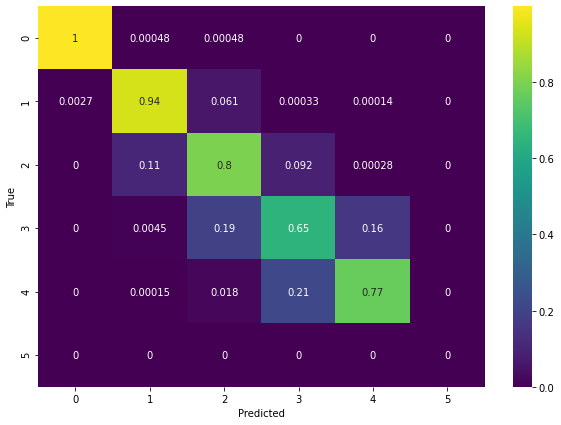

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True");